In [1]:
import pandas as pd
import fastf1 as ff1
import matplotlib.pyplot as plt
from f1_functions import get_lap_times
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image

import urllib
import requests
import os

In [2]:
ff1.Cache.enable_cache('f1/cache')

In [3]:
year = 2023
circuits = ['Bahrain', 'Saudi Arabia', 'Australia']
race_type = 'R'

data = pd.DataFrame()

for race in circuits:
    data = get_lap_times(data, year, race, race_type)

/home/vscode/.local/lib/python3.9/site-packages/fastf1/core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/home/vscode/.local/lib/python3.9/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
/home/vscode/.local/lib/python3.9/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with 

In [4]:
data

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,Year,Circuit
0,0 days 01:04:15.961000,1,NaT,1.0,0 days 00:21:57.509000,NaT,NaT,0 days 00:00:42.414000,0 days 00:00:23.842000,NaT,...,False,1,0 days 01:02:36.652000,Red Bull Racing,VER,2,False,2023-03-05 15:03:38.501,2023,Bahrain
1,0 days 01:05:53.935000,1,0 days 00:01:37.974000,2.0,NaT,NaT,0 days 00:00:31.342000,0 days 00:00:42.504000,0 days 00:00:24.128000,0 days 01:04:47.303000,...,False,1,0 days 01:04:15.961000,Red Bull Racing,VER,2,True,2023-03-05 15:05:17.810,2023,Bahrain
2,0 days 01:07:31.941000,1,0 days 00:01:38.006000,3.0,NaT,NaT,0 days 00:00:31.388000,0 days 00:00:42.469000,0 days 00:00:24.149000,0 days 01:06:25.323000,...,False,1,0 days 01:05:53.935000,Red Bull Racing,VER,1,True,2023-03-05 15:06:55.784,2023,Bahrain
3,0 days 01:09:09.917000,1,0 days 00:01:37.976000,4.0,NaT,NaT,0 days 00:00:31.271000,0 days 00:00:42.642000,0 days 00:00:24.063000,0 days 01:08:03.212000,...,False,1,0 days 01:07:31.941000,Red Bull Racing,VER,1,True,2023-03-05 15:08:33.790,2023,Bahrain
4,0 days 01:10:47.952000,1,0 days 00:01:38.035000,5.0,NaT,NaT,0 days 00:00:31.244000,0 days 00:00:42.724000,0 days 00:00:24.067000,0 days 01:09:41.161000,...,False,1,0 days 01:09:09.917000,Red Bull Racing,VER,1,True,2023-03-05 15:10:11.766,2023,Bahrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0 days 01:09:48.004000,23,0 days 00:01:24.327000,4.0,NaT,NaT,0 days 00:00:29.279000,0 days 00:00:18.408000,0 days 00:00:36.640000,0 days 01:08:52.956000,...,True,1,0 days 01:08:23.677000,Williams,ALB,1,False,2023-04-02 05:09:25.499,2023,Australia
2996,0 days 01:11:11.643000,23,0 days 00:01:23.639000,5.0,NaT,NaT,0 days 00:00:29.185000,0 days 00:00:18.308000,0 days 00:00:36.146000,0 days 01:10:17.189000,...,True,1,0 days 01:09:48.004000,Williams,ALB,1,True,2023-04-02 05:10:49.826,2023,Australia
2997,0 days 01:12:34.992000,23,0 days 00:01:23.349000,6.0,NaT,NaT,0 days 00:00:29.156000,0 days 00:00:18.316000,0 days 00:00:35.877000,0 days 01:11:40.799000,...,True,1,0 days 01:11:11.643000,Williams,ALB,1,True,2023-04-02 05:12:13.465,2023,Australia
2998,0 days 01:16:00.697000,23,NaT,7.0,NaT,NaT,NaT,NaT,NaT,NaT,...,True,1,0 days 01:12:34.992000,Williams,ALB,24,False,2023-04-02 05:13:36.814,2023,Australia


In [5]:
data.columns

Index(['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'PitOutTime',
       'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Stint', 'LapStartTime', 'Team',
       'Driver', 'TrackStatus', 'IsAccurate', 'LapStartDate', 'Year',
       'Circuit'],
      dtype='object')

In [6]:
df = data[['Driver', 'Team', 'LapTime', 'Compound']].groupby(
    ['Driver', 'Team', 'Compound']
).agg({'LapTime': 'mean'}).reset_index()

In [7]:
# add a column that is the number of laps per compound
df['Laps'] = data[['Driver', 'Team', 'LapTime', 'Compound']].groupby(
    ['Driver', 'Team', 'Compound']
).agg({'LapTime': 'count'}).reset_index()['LapTime']

df

,Driver,Team,Compound,LapTime,Laps
0,ALB,Williams,HARD,0 days 00:01:43.052363636,22
1,ALB,Williams,MEDIUM,0 days 00:01:38.500428571,21
2,ALB,Williams,SOFT,0 days 00:01:40.321119047,42
3,ALO,Aston Martin,HARD,0 days 00:01:31.691666666,117
4,ALO,Aston Martin,MEDIUM,0 days 00:01:38.009391304,23
5,ALO,Aston Martin,SOFT,0 days 00:01:40.198153846,13
6,BOT,Alfa Romeo,HARD,0 days 00:01:33.790807692,104
7,BOT,Alfa Romeo,MEDIUM,0 days 00:01:39.203480,25
8,BOT,Alfa Romeo,SOFT,0 days 00:01:38.440208333,24
9,DEV,AlphaTauri,HARD,0 days 00:01:40.298734939,83


In [8]:
# Convert the LapTime column to seconds
df['LapTime'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()

In [9]:
# Create three columns for lap times based on the compound
df['Soft'] = df['LapTime'].where(df['Compound'] == 'SOFT')
df['Medium'] = df['LapTime'].where(df['Compound'] == 'MEDIUM')
df['Hard'] = df['LapTime'].where(df['Compound'] == 'HARD')

In [10]:
# Create three columns for the count of laps based on the compound
df['SoftLaps'] = df['Laps'].where(df['Compound'] == 'SOFT')
df['MediumLaps'] = df['Laps'].where(df['Compound'] == 'MEDIUM')
df['HardLaps'] = df['Laps'].where(df['Compound'] == 'HARD')

In [11]:
# Drop the compound column
df = df.drop(columns=['Compound'])

In [12]:
# Combine each row into a single row for each driver
df = df.groupby(['Driver', 'Team']).agg({'Soft': 'mean', 'Medium': 'mean', 'Hard': 'mean', 'SoftLaps': 'last', 'MediumLaps': 'last', 'HardLaps': 'last'}).reset_index()

In [13]:
# Replace each time with the delta from the average for that compound
df['Soft'] = df['Soft'] - df['Soft'].mean()
df['Medium'] = df['Medium'] - df['Medium'].mean()
df['Hard'] = df['Hard'] - df['Hard'].mean()

In [14]:
# Order ascending by the sum of the deltas
df = df.assign(
    sum=df[['Soft', 'Medium', 'Hard']].sum(axis=1)
).sort_values('sum', ascending=True).drop(columns=['sum'])

In [15]:
# Create a dataframe just for the hard compound and sort by the delta
hard = df[['Driver', 'Team', 'Hard', 'HardLaps']].sort_values('Hard', ascending=True)

In [16]:
hard

,Driver,Team,Hard,HardLaps
18,VER,Red Bull Racing,-4.282731,96.0
11,PER,Red Bull Racing,-3.784861,102.0
16,STR,Aston Martin,-2.317239,90.0
1,ALO,Aston Martin,-2.308439,117.0
12,PIA,McLaren,-1.820116,94.0
19,ZHO,Alfa Romeo,-1.775208,78.0
9,NOR,McLaren,-1.751827,79.0
4,GAS,Alpine,-1.228484,111.0
5,HAM,Mercedes,-1.075405,107.0
14,SAI,Ferrari,-0.890455,123.0


In [17]:
# Create a new column that holds the filepath to the teams logo
hard['Logo'] = hard['Team'].apply(lambda x: f'images/{x}.jpg')

In [18]:
# Replace the index with the driver column
hard = hard.set_index('Logo')

In [19]:
# Round each delta to 3 decimal places
hard['Hard'] = hard['Hard'].round(3)

# Round the lap count to 0 decimal places
hard['HardLaps'] = hard['HardLaps'].round(0)

In [21]:
# Put the columns in the order Logo, Driver, Team, Hard, HardLaps
hard = hard[['Team', 'Hard', 'HardLaps']]

In [22]:
hard

,Team,Hard,HardLaps
Logo,,,
images/Red Bull Racing.jpg,Red Bull Racing,-4.283,96.0
images/Red Bull Racing.jpg,Red Bull Racing,-3.785,102.0
images/Aston Martin.jpg,Aston Martin,-2.317,90.0
images/Aston Martin.jpg,Aston Martin,-2.308,117.0
images/McLaren.jpg,McLaren,-1.820,94.0
images/Alfa Romeo.jpg,Alfa Romeo,-1.775,78.0
images/McLaren.jpg,McLaren,-1.752,79.0
images/Alpine.jpg,Alpine,-1.228,111.0
images/Mercedes.jpg,Mercedes,-1.075,107.0


In [23]:
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"


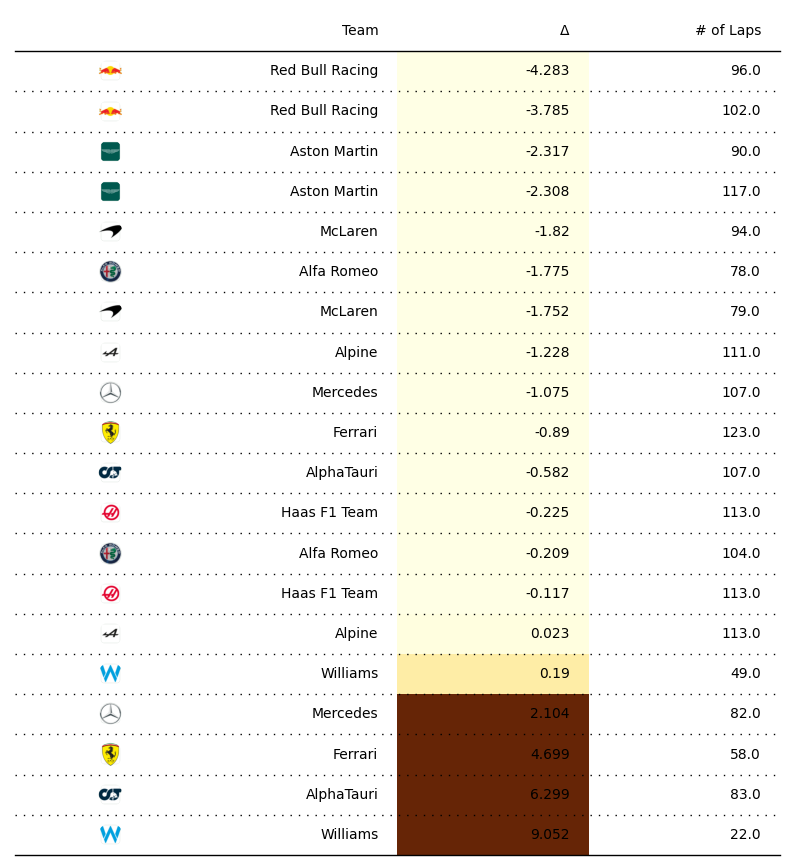

In [24]:
fig, ax = plt.subplots(figsize=(10, 11))

# Create plottable tables for the hard compound
hard_table = Table(
    hard,
    row_dividers=True,
    footer_divider=True,
    column_definitions= [
        ColumnDefinition('Driver', title='Driver'),
        ColumnDefinition('Team', title='Team'),
        ColumnDefinition('Logo', title='', plot_fn=circled_image),
        ColumnDefinition('Hard', title='Δ', cmap=plt.cm.YlOrBr),
        ColumnDefinition('HardLaps', title='# of Laps',)
    ],
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"}
)